In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
import utils.data_loader as data_loader, utils.models as models, train
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [24]:
hidden_dim = 200
latent_dim = 2
c = 4
batch_size = 64

lr = 1e-3
epochs = 10

is_cuda = True

In [25]:
dataloader_train, dataloader_valid = data_loader.CustomDataloaders.MNIST()
if is_cuda:
    device = torch.device('cuda:0')
else:   
    device = torch.device('cpu')
model = models.VaeFc(hidden_dim=hidden_dim, latent_dim=latent_dim, c=c).to(device)

In [26]:
#### Training script

optim = torch.optim.Adam(model.parameters(), lr=lr)
epoch_loss = 0

for epoch in range(epochs):
    print(f'Epoch: {epoch:2}')
    nb_items = 0
    epoch_loss = 0
    for n, batch in enumerate(dataloader_train):
        model.train()
        x, _ = batch
        x = x.to(device)
        y_hat, mean, logvar = model.forward(x)
        loss = model.calculate_loss(x, y_hat, mean, logvar)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.detach()
        if (n+1)%2000 == 0:
            print(f'    loss: {loss:12.3f}')
    print(f'  epoch loss: {epoch_loss/n:5.3f}')
print('Training Complete')

        

Epoch:  0


  epoch loss: 720.087
Epoch:  1
  epoch loss: 621.218
Epoch:  2
  epoch loss: 595.812
Epoch:  3
  epoch loss: 580.023
Epoch:  4
  epoch loss: 570.199
Epoch:  5
  epoch loss: 562.935
Epoch:  6
  epoch loss: 557.814
Epoch:  7
  epoch loss: 553.197
Epoch:  8
  epoch loss: 549.728
Epoch:  9
  epoch loss: 547.637
Training Complete


In [27]:
model.eval()
model.to('cpu')
x, _ = next(iter(dataloader_train))

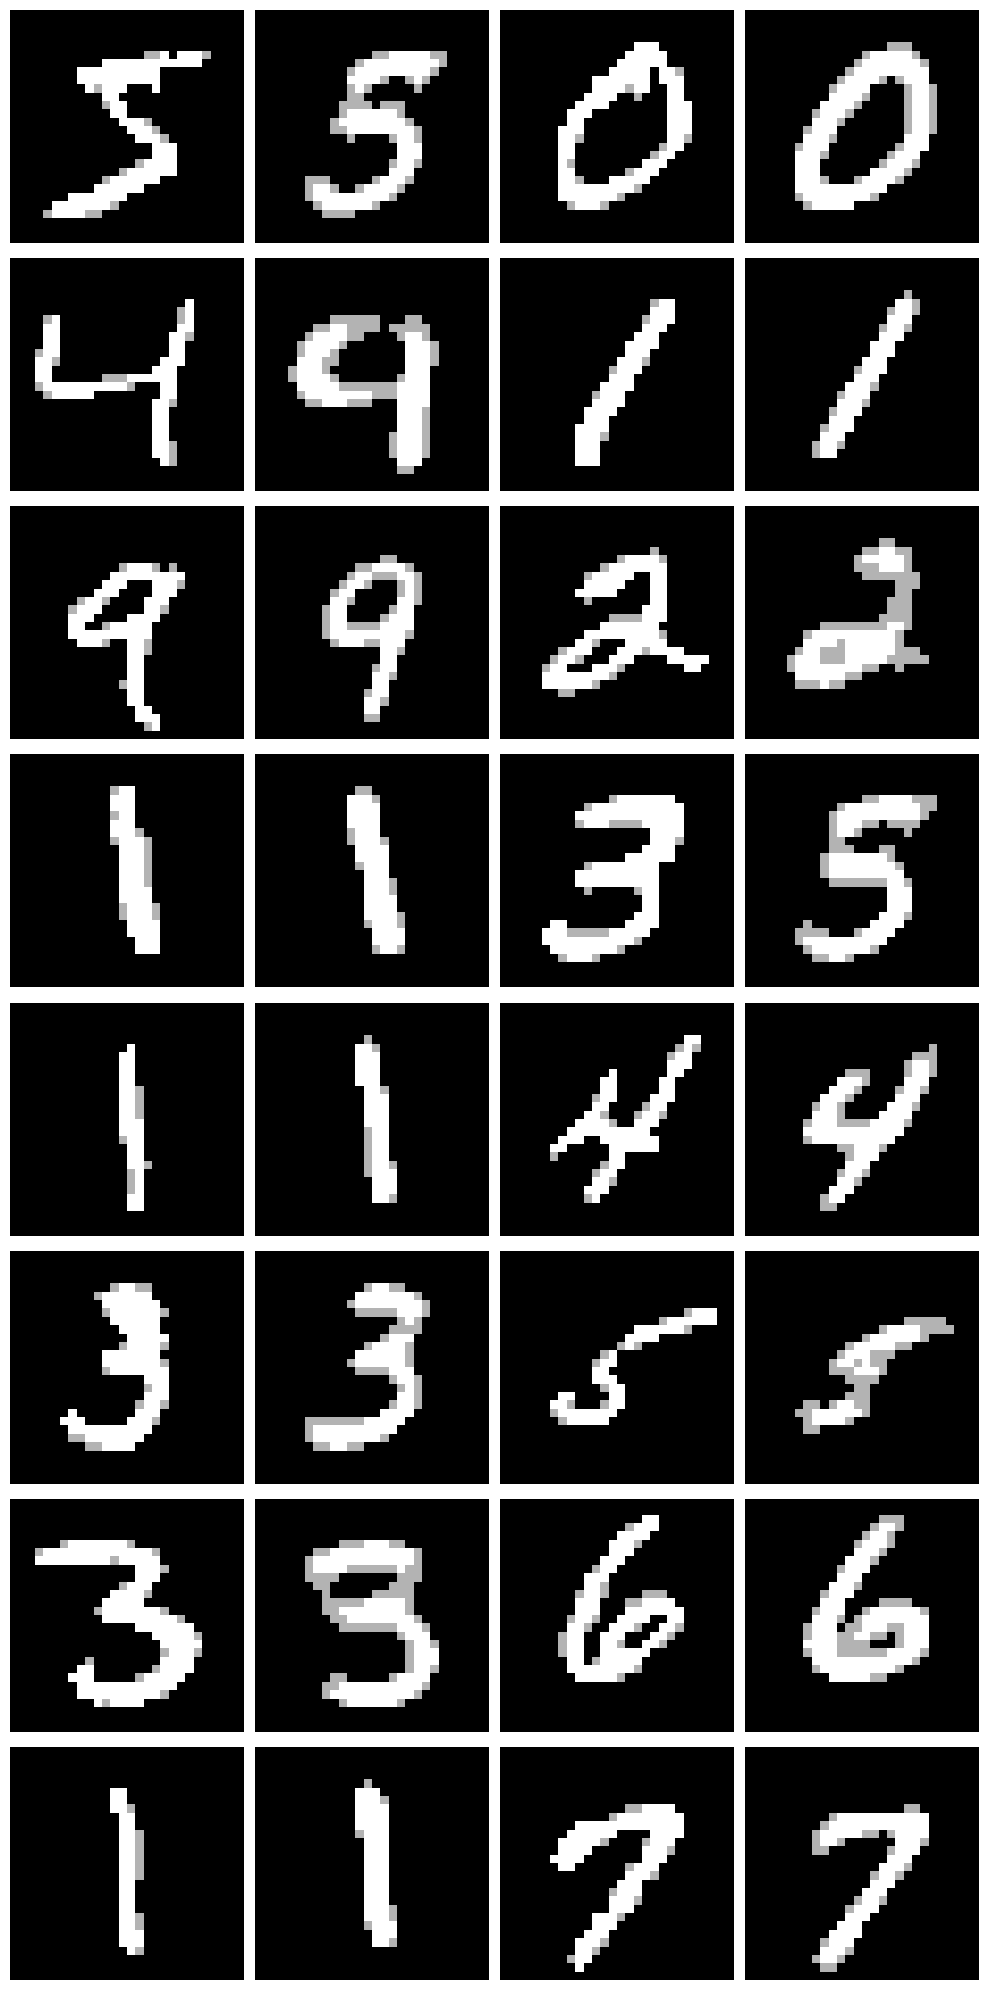

In [28]:
# Map predicted output next to input

x_hat, _ = model(x)
# Create a figure and axes for plotting
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(10, 20))
rows = 8
cols = 4
thresh_low = 0.4
thresh_high = 0.6
mid = 0.7

# Loop through each row
for i in range(rows):
    # Alternate between x and x_hat in each row
    for j in range(cols):
        if j % 2 == 0:
            img = x[i * (cols // 2) + (j // 2)][0].detach().numpy()  # Extracting an image from x
        else:
            img = x_hat[i * (cols // 2) + (j // 2)][0].detach().numpy()  # Extracting an image from x_hat

        img = np.where(img > thresh_low, np.where(img > thresh_high, 1, mid), 0)
        # Plot the image
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


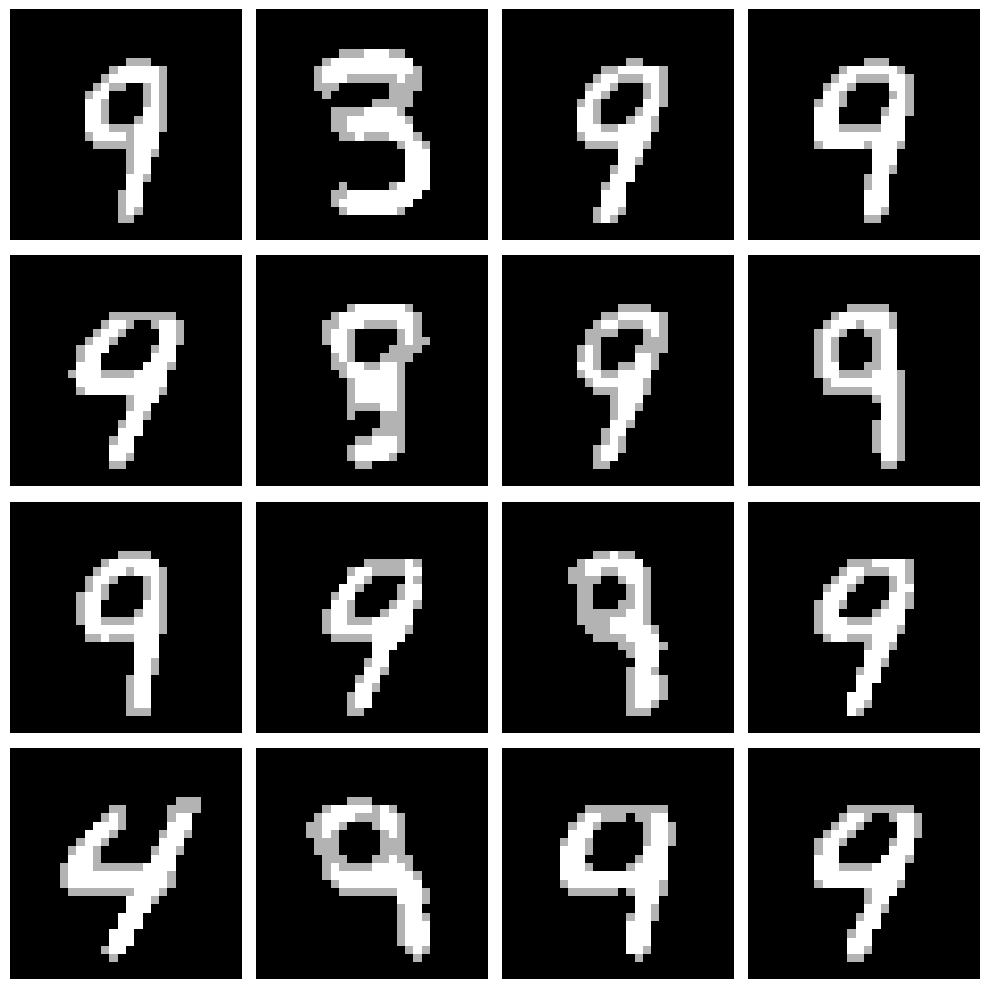

In [29]:
idx = 4
eps = -1.5
mean, _ = model.encoder(x)
mean_one = torch.zeros(size=(16, mean.shape[1]))
mean_one[:] = mean[idx]
logvar_one = torch.ones_like(mean_one)
x_hat = model.decoder(mean_one, eps * logvar_one).detach()

# change latent space to get different outputs

img = x_hat.squeeze(1).numpy()
tensor_of_images = np.where(img > thresh_low, np.where(img > thresh_high, 1, mid), 0)

# Create a figure and axes
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Plot each image in the grid
for i in range(16):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(tensor_of_images[i], cmap='gray')  # Assuming the images are grayscale
    ax.axis('off')  # Turn off axis labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_1320/2418600302.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(start=-max_x, end=max_x, step=2*max_x/(n-1))
/tmp/ipykernel_1320/2418600302.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  y = torch.range(start=-max_x, end=max_x, step=2*max_x/(n-1))


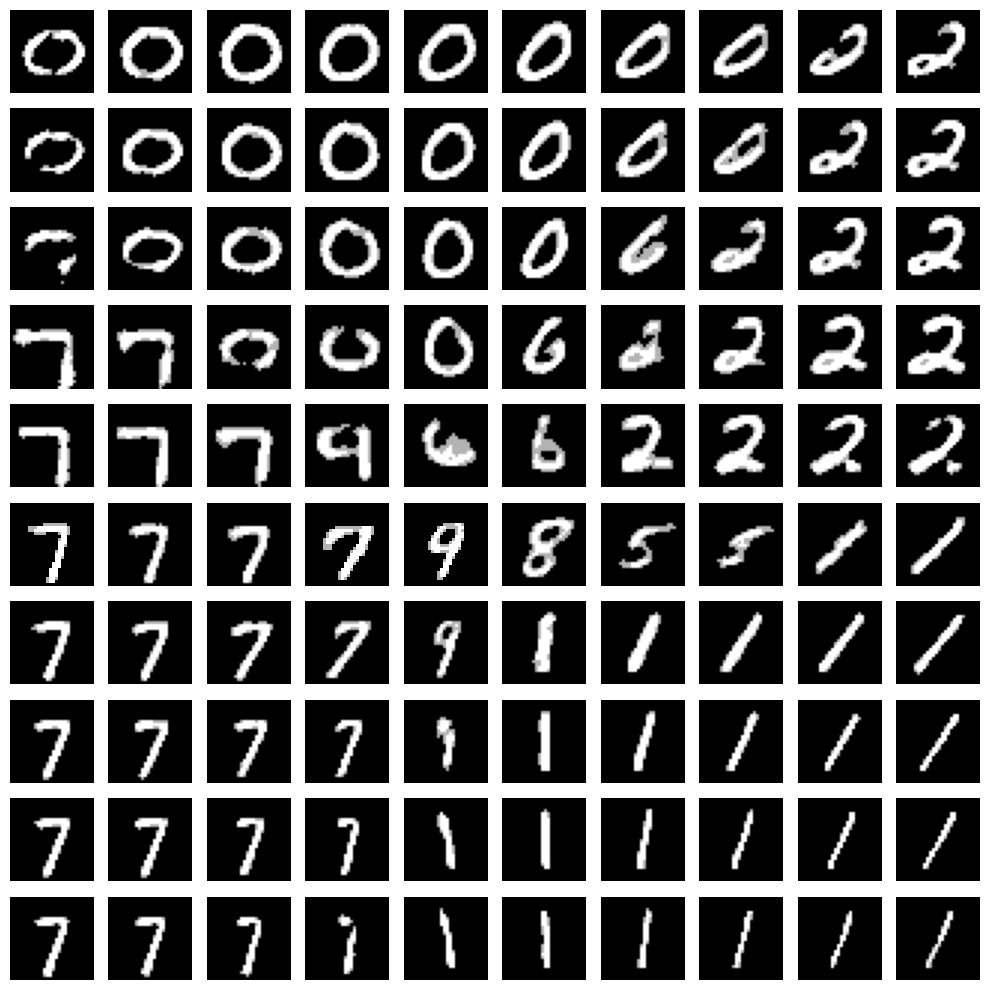

In [30]:
max_x = 4
n = 10
x = torch.range(start=-max_x, end=max_x, step=2*max_x/(n-1))
y = torch.range(start=-max_x, end=max_x, step=2*max_x/(n-1))
x, y = torch.meshgrid([x,y])

batch = torch.vstack([x.flatten(), y.flatten()]).permute(1,0)
x_hat = model.decoder(batch, -100 * torch.ones_like(batch)).detach()
x_hat = x_hat.squeeze(1).numpy()
x_hat = np.where(x_hat > thresh_low, np.where(x_hat > thresh_high, 1, mid), 0)

# Create a figure and axes
fig, axes = plt.subplots(n, n, figsize=(n, n))

# Plot each image in the grid
for i, ax in enumerate(axes.flatten()):
    img = x_hat[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
device

device(type='cuda', index=0)

In [34]:
nb_batches = 20
nb_total = nb_batches * batch_size
encoded_data = torch.zeros(size=(nb_total, latent_dim))
labels = torch.zeros(nb_total)
model.to(device)
for i, batch in enumerate(dataloader_train):
    x, y = batch
    labels[i * batch_size:(i+1) * batch_size] = y
    means, _ = model.encoder(x.to(device))
    means = means.to('cpu')
    encoded_data[i * batch_size: (i+1) * batch_size] = means
    if i + 1 == nb_batches:
        break
labels = labels.detach().numpy()
encoded_data = encoded_data.detach().numpy()

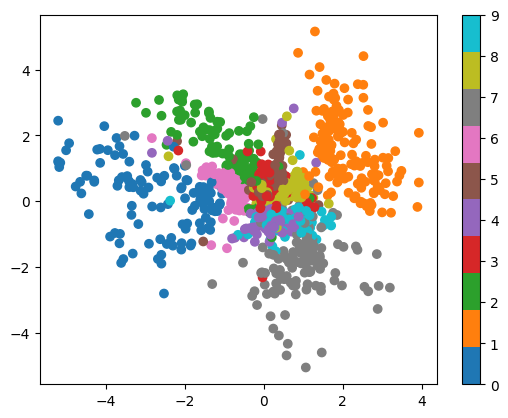

In [35]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cmap = ListedColormap(colors)

plt.scatter(encoded_data[:,0], encoded_data[:,1], c=labels, cmap=cmap)
plt.colorbar()